In [1]:
import os

import geopandas as gpd
import nivapy3 as nivapy
import pandas as pd
from shapely.geometry import box
from sqlalchemy import text

In [2]:
eng = nivapy.da.connect_postgis()

Connection successful.


# Identify river outlets

Identifying river outlet points above a certain size (stream order) within an area of interest.

## 1. User inputs

In [3]:
# CRS to work in
epsg = 25833

# Define area of interest. Provide lower-left corner of bounding box
# in the units of the CRS chosen above. Then provide width and height in km
xmin, ymin = 635000, 7700000
width_km, height_km = 40, 40

# Buffer to apply to coastline to ensure rivers meet coast. In units of CRS
# chosen above
buffer = 10

# Smallest ELVIS stream order to keep
min_order = 3

# NVE flow series to use. Year of data supply
nve_data_year = 2024

# Period of interest for flow data
st_yr, end_yr = 2017, 2023

# Output time resolution for discharge ('daily', 'monthly', 'annual')
t_res = "daily"

# Folder to save output
output_dir = "/home/jovyan/shared/common/JES/terrestrial_fluxes"

In [4]:
if t_res not in ["daily", "monthly", "annual"]:
    raise ValueError("'t_res' must be one of ['daily', 'monthly', 'annual'].")

## 2. Identify river outlets

In [5]:
# Create folders for results
for dir_name in ["shp", "csv"]:
    dir_path = os.path.join(output_dir, dir_name)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Create bounding box
xmax = xmin + (width_km * 1000)
ymax = ymin + (height_km * 1000)
bbox = box(xmin, ymin, xmax, ymax)

# Read rivers
riv_gdf = (
    nivapy.da.read_postgis("physical", "norway_nve_elvis_river_network_line", eng)
    .query("elveorden >= @min_order")
    .to_crs(f"epsg:{epsg}")
    .clip(bbox)
)

# Read N50 surface cover and get just the sea
sea_gdf = (
    gpd.read_file(
        r"/home/jovyan/shared/common/JES/n50_kartdata/N50_Kartdata.gdb",
        layer="N50_ArealdekkeFlate",
    )
    .query("OBJTYPE == 'Havflate'")
    .to_crs(f"epsg:{epsg}")
    .clip(bbox)
)

# Dissolve sea
sea_gdf["dissolve"] = 1
sea_gdf = sea_gdf.dissolve(by="dissolve")

# Buffer
sea_gdf["geometry"] = sea_gdf["geometry"].buffer(buffer)

# Calculate intersections
outlet_gdf = sea_gdf.set_geometry(sea_gdf.boundary).overlay(
    riv_gdf, keep_geom_type=False
)
assert outlet_gdf["elvid"].is_unique
outlet_gdf["easting"] = outlet_gdf.geometry.x
outlet_gdf["northing"] = outlet_gdf.geometry.y
outlet_df = outlet_gdf[["elvid", "vassdragnr", "easting", "northing"]]

/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:194: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  result = ogr_read(
/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/opt/conda/lib/python3.11/site-packages/pyogrio/geopandas.py:54: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, utc=True, **datetime_kwargs)


<Axes: >

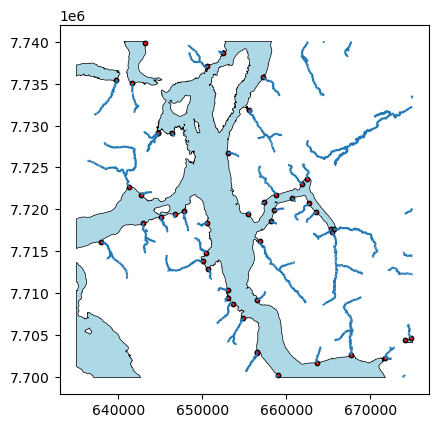

In [6]:
# Plot
ax = sea_gdf.plot(facecolor="lightblue", edgecolor="k", lw=0.5)
riv_gdf.plot(ax=ax)
outlet_gdf.plot(ax=ax, marker="o", color="red", edgecolor="black", markersize=10)

## 3. Catchment boundaries

In [7]:
# Catchment boundaries
cat_gdf = nivapy.spatial.derive_watershed_boundaries(
    outlet_df,
    id_col="elvid",
    xcol="easting",
    ycol="northing",
    crs=f"epsg:{epsg}",
    min_size_km2=0.1,
    dem_res_m=40,
    reproject=True,
)
cat_gdf["area_km2"] = cat_gdf.to_crs({"proj": "cea"})["geometry"].area / 1e6

Connection successful.


Looping over vassdragsområder:   0%|          | 0/4 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 197:   0%|          | 0/10 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 198:   0%|          | 0/34 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 199:   0%|          | 0/3 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 203:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# Save shapefiles
sea_gdf.to_file(os.path.join(output_dir, "shp", "sea.shp"))
riv_gdf.to_file(os.path.join(output_dir, "shp", "rivers.shp"))
cat_gdf.to_file(os.path.join(output_dir, "shp", "catchments.shp"))
outlet_gdf.to_file(os.path.join(output_dir, "shp", "outlets.shp"))

/tmp/ipykernel_14368/3126863109.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sea_gdf.to_file(os.path.join(output_dir, "shp", "sea.shp"))
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:530: RuntimeWarning: Normalized/laundered field name: 'OPPDATERINGSDATO' to 'OPPDATERIN'
  ogr_write(
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:530: RuntimeWarning: Normalized/laundered field name: 'Shape_Length' to 'Shape_Leng'
  ogr_write(
/tmp/ipykernel_14368/3126863109.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  outlet_gdf.to_file(os.path.join(output_dir, "shp", "outlets.shp"))
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:530: RuntimeWarning: Normalized/laundered field name: 'OPPDATERINGSDATO' to 'OPPDATERIN'
  ogr_write(
/opt/conda/lib/python3.11/site-packages/pyogrio/raw.py:530: RuntimeWarning: Normalized/laundered field name: 'Shape_Length' to

## 4. Scale flows

In [9]:
resamp_dict = {"daily": "D", "monthly": "MS", "annual": "YS"}

# Get vassom data
vassom_gdf = nivapy.da.read_postgis("physical", "norway_nve_vassdragomrade_poly", eng)

# Loop over catchments
df_list = []
for idx, row in cat_gdf.iterrows():
    elvid = row["elvid"]
    vassom = row["vassdragnr"].split(".")[0]
    cat_area_km2 = row["area_km2"]
    vassom_area_km2 = vassom_gdf.query("vassdragsomradenr == @vassom")[
        "arealland_km2"
    ].iloc[0]
    assert cat_area_km2 < vassom_area_km2
    area_fac = cat_area_km2 / vassom_area_km2

    # Get NVE data for vassom
    sql = text(
        "SELECT * FROM teotil3.nve_hbv_discharge "
        "WHERE data_supply_year = :nve_data_year "
        "AND vassom = :vassom"
    )
    q_df = pd.read_sql(
        sql, eng, params={"nve_data_year": nve_data_year, "vassom": vassom}
    )[["date", "flow_m3/s"]]

    # Scale flows
    q_df["flow_m3/s"] = area_fac * q_df["flow_m3/s"]

    # Resample to output frequency
    q_df = q_df.set_index("date").resample(resamp_dict[t_res]).mean().reset_index()

    q_df["elvid"] = elvid

    df_list.append(q_df)

q_df = pd.concat(df_list, axis="rows")
q_df = q_df[["elvid", "date", "flow_m3/s"]]

# Save
outlet_csv_path = os.path.join(output_dir, "csv", "outlets.csv")
outlet_df.to_csv(outlet_csv_path, index=False)

flow_csv_path = os.path.join(output_dir, "csv", "flows.csv")
q_df.to_csv(flow_csv_path, index=False)

q_df.head()

,elvid,date,flow_m3/s
0,197-150-1,1990-01-01,0.571889
1,197-150-1,1990-01-02,0.415893
2,197-150-1,1990-01-03,0.379367
3,197-150-1,1990-01-04,0.360439
4,197-150-1,1990-01-05,0.344834
